<a href="https://colab.research.google.com/github/ShannieChacham/Workout_Exercises_Video_Classifier/blob/main/Shannie_Chacham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
from pathlib import Path
from datetime import datetime
from collections import defaultdict
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


zip_path = "/content/drive/MyDrive/Beilinson/dataset.zip"

extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

output_path = "/content/drive/MyDrive/Beilinson/figs"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


# **Exploratory Data Analysis**


In [ ]:
def video_duration_sec(video_path: Path) -> float:
    try:
        cap = cv2.VideoCapture(str(video_path))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        cap.release()
        return round(frames / fps, 2) if fps else 0.0
    except Exception as e:
        print(f"[ERROR] {video_path}: {e}")
        return 0.0

def seconds_to_mmss(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    return f"{m}:{s:02d}"

# def mmss_to_seconds(t: str) -> int:
#     m, s = map(int, t.split(":"))
#     return m * 60 + s

def gather_video_metadata(root_dir: str) -> pd.DataFrame:
    video_exts = {'.mp4', '.avi', '.mov', '.mkv', '.wmv'}
    records = []

    for video_file in Path(root_dir).rglob("*"):
        if video_file.suffix.lower() in video_exts:
            try:
                category = video_file.parent.name
                size_mb = round(video_file.stat().st_size / (1024 ** 2), 2)
                modified = datetime.fromtimestamp(video_file.stat().st_mtime).strftime('%Y-%m-%d %H:%M')
                duration = video_duration_sec(video_file)
                records.append({
                    'Category': category,
                    'Filename': video_file.name,
                    'Format': video_file.suffix[1:],
                    'Size_MB': size_mb,
                    'Duration_sec': duration,
                    'Modified': modified
                })
            except Exception as e:
                print(f"[ERROR] Failed to process {video_file}: {e}")

    return pd.DataFrame(records)

def summarize_videos(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    summary = (
        df.groupby('Category')
          .agg(
              Total_Videos=('Filename', 'count'),
              Formats=('Format', lambda x: ', '.join(f"{f}: {x.tolist().count(f)}" for f in set(x))),
              Total_Size_MB=('Size_MB', 'sum'),
              Size_Std_MB=('Size_MB', lambda x: round(x.std(), 2) if len(x) > 1 else 0),
              Total_Duration=('Duration_sec', 'sum'),
              Duration_Std=('Duration_sec', lambda x: x.std() if len(x) > 1 else 0)
          )
          .reset_index()
    )

    summary['Total_Duration'] = summary['Total_Duration'].apply(seconds_to_mmss)
    summary['Duration_Std'] = summary['Duration_Std'].apply(seconds_to_mmss)

    # Add overall total row
    total_row = {
        'Category': 'All',
        'Total_Videos': df.shape[0],
        'Formats': 'All',
        'Total_Size_MB': round(df['Size_MB'].sum(), 2),
        'Size_Std_MB': round(df['Size_MB'].std(), 2) if len(df) > 1 else 0,
        'Total_Duration': seconds_to_mmss(df['Duration_sec'].sum()),
        'Duration_Std': seconds_to_mmss(df['Duration_sec'].std() if len(df) > 1 else 0)
    }
    summary = pd.concat([summary, pd.DataFrame([total_row])], ignore_index=True)

    return summary


def analyze_video_data(df: pd.DataFrame, summary_df: pd.DataFrame, output_dir: str = "./figs"):
    os.makedirs(output_dir, exist_ok=True)

    print("Summary Overview:")
    display(summary_df)
    print("\nVideo Details:")
    display(df.head())

    fig_size = (12, 6)

    # Bar plot: number of videos per category
    plt.figure(figsize=fig_size)
    video_counts = df['Category'].value_counts()
    bars = plt.bar(video_counts.index, video_counts.values, color='skyblue')
    plt.title("Number of Videos by Category")
    plt.xlabel("Exercise Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{int(bar.get_height())}", ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/video_count_per_category.png")
    plt.show()

    # Boxplot: duration by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category.png")
    plt.show()

    # Boxplot: duration by category without outliers
    no_outliers_df = df[~df['Category'].isin(['plank', 'romanian deadlift'])]

    plt.figure(figsize=fig_size)
    sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category Without Outliers")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category_without_outliers.png")
    plt.show()

    # Boxplot: duration by category for short clips only
    short_df = df[df['Duration_sec'] < 60]
    if not short_df.empty:
        plt.figure(figsize=fig_size)
        sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')
        plt.title("Short Videos (<60s) by Category")
        plt.xlabel("Exercise")
        plt.ylabel("Seconds")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/short_videos_boxplot.png")
        plt.show()

    # Boxplot: video file size by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')
    plt.title("Video File Size by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Size (MB)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/size_by_category.png")
    plt.show()

In [ ]:
video_df = gather_video_metadata("/content/dataset")
summary_df = summarize_videos(video_df)


Summary Overview:


,Category,Total_Videos,Formats,Total_Size_MB,Size_Std_MB,Total_Duration,Duration_Std
0,barbell biceps curl,62,mp4: 62,82.84,1.67,3:58,0:02
1,bench press,61,mp4: 61,110.92,2.97,3:49,0:04
2,chest fly machine,28,mp4: 28,55.33,4.24,2:55,0:05
3,deadlift,32,mp4: 32,65.31,4.53,3:07,0:06
4,decline bench press,12,"mp4: 6, MOV: 6",427.35,36.18,2:58,0:08
5,hammer curl,19,"mp4: 12, MOV: 7",364.64,19.80,3:05,0:05
6,hip thrust,18,"mp4: 14, MOV: 4",251.24,15.29,3:33,0:09
7,incline bench press,33,mp4: 33,140.33,8.19,4:25,0:11
8,lat pulldown,51,mp4: 51,107.20,2.22,3:41,0:02
9,lateral raise,37,"mp4: 31, MOV: 6",422.71,16.90,5:07,0:04



Video Details:


,Category,Filename,Format,Size_MB,Duration_sec,Modified
0,t bar row,t bar row_5.MOV,MOV,30.81,14.85,2025-07-22 07:34
1,t bar row,t bar row_6.MOV,MOV,27.97,13.48,2025-07-22 07:34
2,t bar row,t bar row_11.mp4,mp4,3.24,5.17,2025-07-22 07:34
3,t bar row,t bar row_13.mp4,mp4,2.45,3.59,2025-07-22 07:34
4,t bar row,t bar row_2.MOV,MOV,36.11,17.15,2025-07-22 07:34


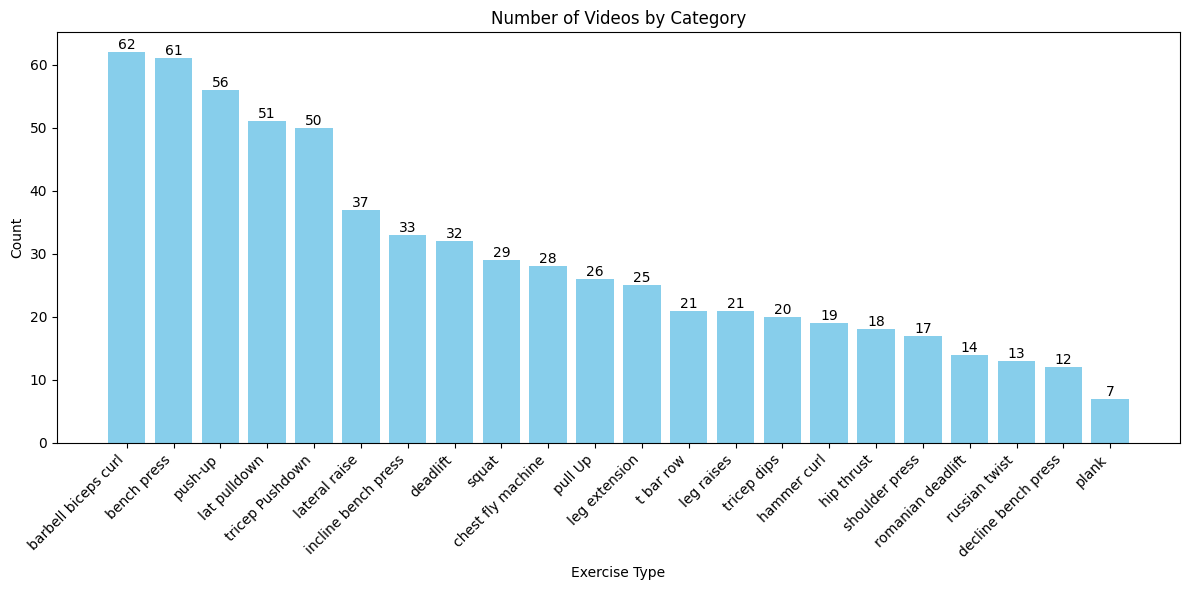

/tmp/ipython-input-12-2842082394.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')


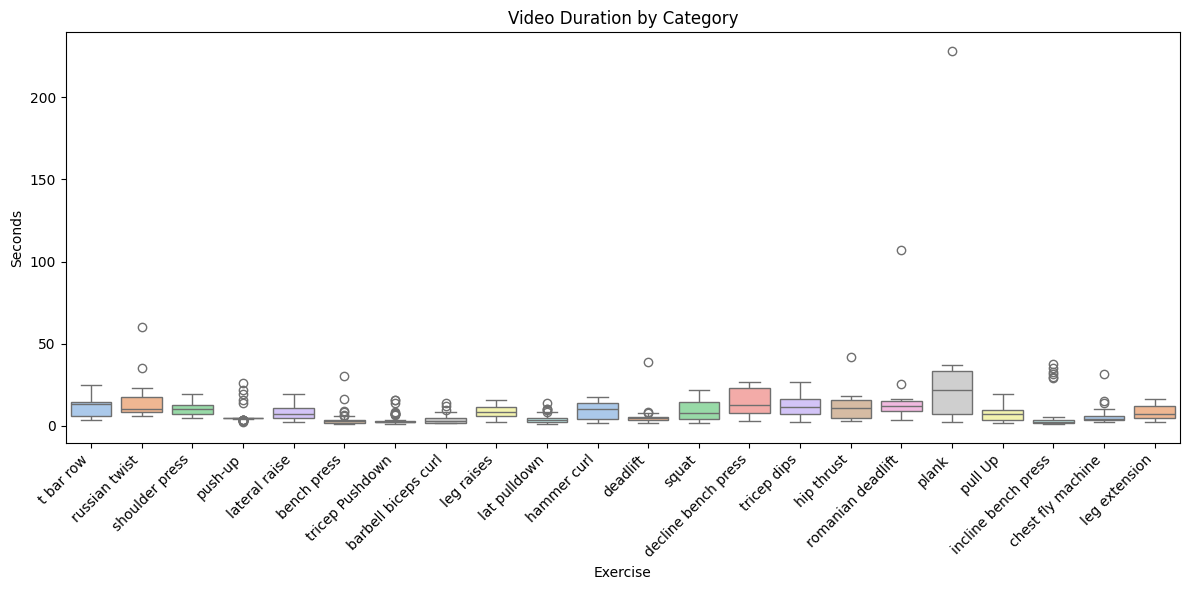

/tmp/ipython-input-12-2842082394.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')


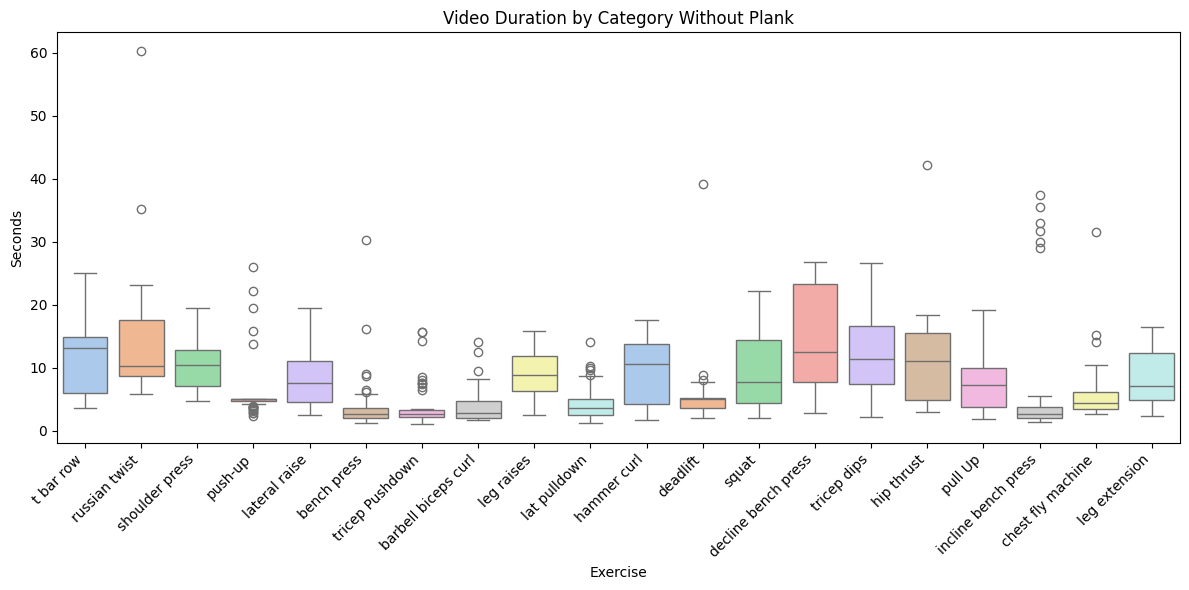

/tmp/ipython-input-12-2842082394.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')


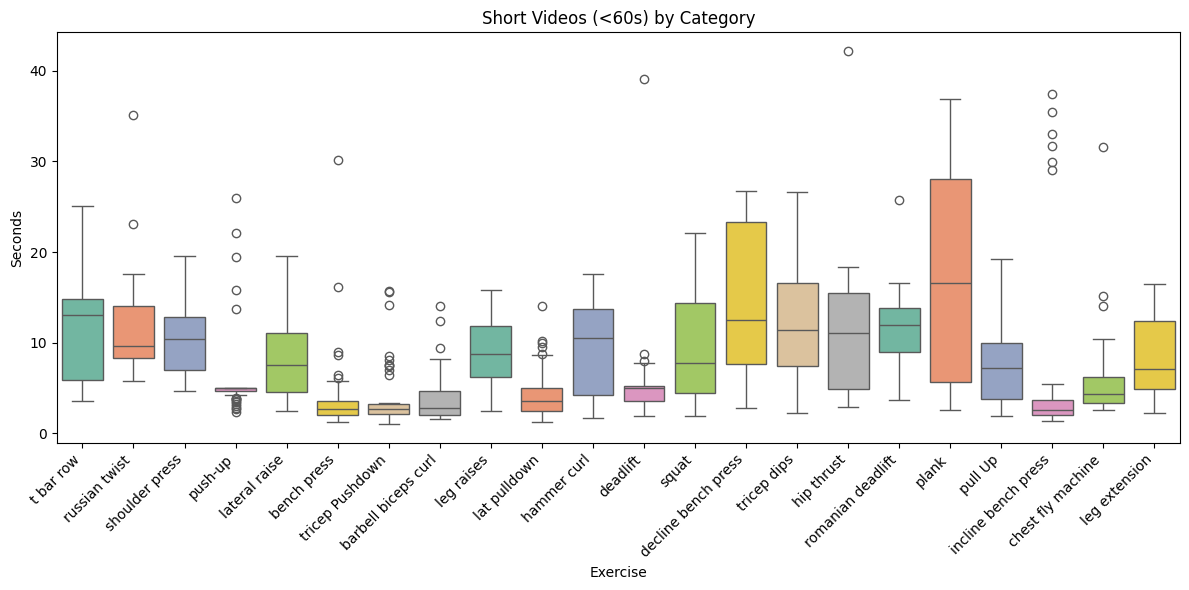

/tmp/ipython-input-12-2842082394.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')


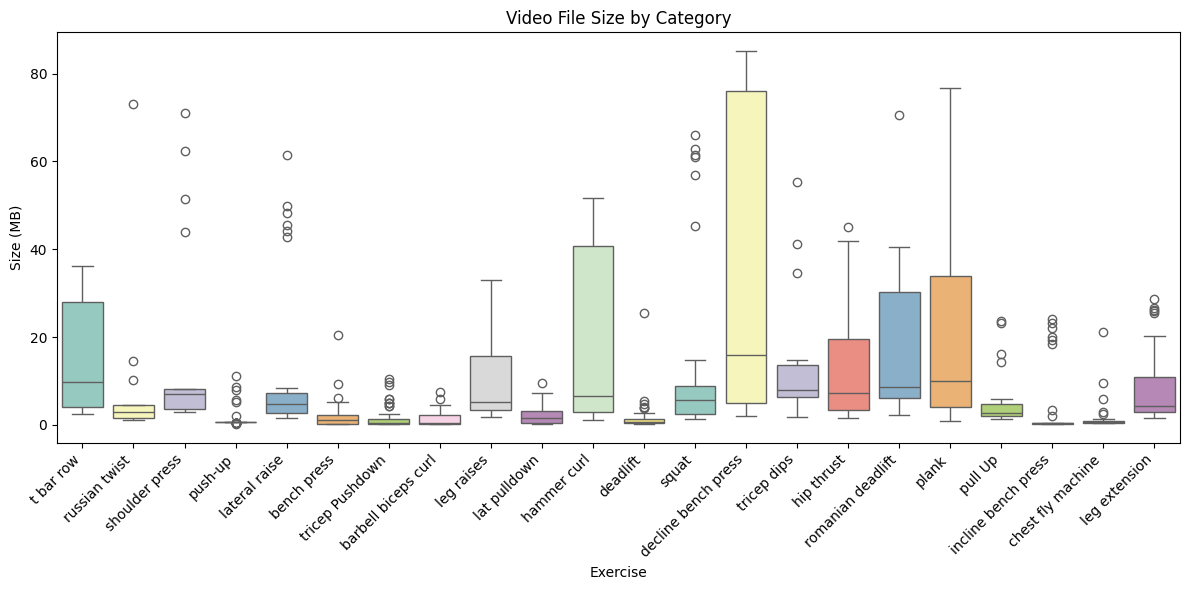

In [ ]:
analyze_video_data(video_df, summary_df, output_dir=output_path)

# **Data Preprocess**

In [ ]:
!pip install torchvision opencv-python


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from glob import glob
from typing import List, Tuple
from sklearn.model_selection import train_test_split


In [ ]:
def build_dataframe_from_folder(root_dir: str, extensions=('.mp4', '.avi', '.mov')) -> Tuple[pd.DataFrame, dict]:
    data = []
    label_map = {}
    for i, class_folder in enumerate(sorted(os.listdir(root_dir))):
        class_path = os.path.join(root_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        label_map[class_folder] = i
        for fname in glob(os.path.join(class_path, '*')):
            if fname.lower().endswith(extensions):
                data.append({
                    'filepath': fname,
                    'label': i,
                    'category': class_folder
                })
    return pd.DataFrame(data), label_map


In [ ]:
root_dir = "/content/dataset"
df, label_map = build_dataframe_from_folder(root_dir)
df.head()


### **Data Split**

In [ ]:
def build_split_csv(df: pd.DataFrame, output_dir: str, train_size=0.7, val_size=0.15, seed=42):
    # First, split to train and temp
    train_df, temp_df = train_test_split(df, test_size=1-train_size, stratify=df['Category'], random_state=seed)

    # Then split temp into val and test
    relative_val_size = val_size / (1 - train_size)
    val_df, test_df = train_test_split(temp_df, test_size=1 - relative_val_size, stratify=temp_df['Category'], random_state=seed)

    # Save as CSVs
    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/train.csv", index=False)
    val_df.to_csv(f"{output_dir}/val.csv", index=False)
    test_df.to_csv(f"{output_dir}/test.csv", index=False)

    return train_df, val_df, test_df

In [ ]:
splits_dir = "/content/drive/MyDrive/Beilinson/splits"

train_df, val_df, test_df = build_split_csv(video_df, output_dir=splits_dir)


In [ ]:
# Count per category for each split
train_counts = train_df['Category'].value_counts().rename('Train')
val_counts = val_df['Category'].value_counts().rename('Validation')
test_counts = test_df['Category'].value_counts().rename('Test')

# Combine into single DataFrame
split_summary = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)

# Display the summary
display(split_summary)


,Train,Validation,Test
Category,,,
bench press,43,9,9
barbell biceps curl,43,9,10
push-up,39,8,9
lat pulldown,36,7,8
tricep Pushdown,35,7,8
lateral raise,26,5,6
incline bench press,23,5,5
deadlift,22,5,5
squat,20,5,4


### **Video Dataset Construction**

The `VideoClipDataset` class loads short clips from raw video files for training 3D CNN models.
For each video sample, it:

* Extracts a clip of 16 consecutive frames from **the middle of the video** (center-based uniform sampling)

* Applies resizing, normalization, and format conversion to each frame

* Stacks the frames into a tensor of shape (3, 16, 112, 112)

* Returns the clip and its corresponding label for classification tasks

This allows efficient, on-the-fly loading of consistent video inputs during training without preprocessing the entire dataset.

In [ ]:
class VideoClipDataset(Dataset):
    def __init__(self, df: pd.DataFrame, clip_len: int = 16, resize: Tuple[int, int] = (112, 112)):
        self.df = df.reset_index(drop=True)
        self.clip_len = clip_len
        self.resize = resize

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def _sample_clip_indices(self, total_frames: int) -> List[int]:
        mid = total_frames // 2
        start = max(0, mid - self.clip_len // 2)
        return list(range(start, min(start + self.clip_len, total_frames)))

    def _load_video_clip(self, path: str) -> torch.Tensor:
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_indices = self._sample_clip_indices(total_frames)
        frames = []
        for i in range(max(frame_indices) + 1):
            ret, frame = cap.read()
            if not ret:
                break
            if i in frame_indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = self.transform(frame)
                frames.append(frame)

        cap.release()

        while len(frames) < self.clip_len:
            frames.append(frames[-1])

        clip = torch.stack(frames[:self.clip_len], dim=1)  # Shape: [C, T, H, W]
        return clip

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        clip = self._load_video_clip(row['filepath'])
        label = row['label']
        return clip, label


In [ ]:
sample_dataset = VideoClipDataset(train_df)
sample_clip, sample_label = sample_dataset[0]

print("Clip shape:", sample_clip.shape)  # Should be [3, 16, 112, 112]
print("Label:", sample_label)


# **Model Architecture**

In [ ]:
print('hello')